In [1]:
from __future__ import print_function

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import Parameter
from torch.autograd import Variable

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import time
import datetime
import math, cv2, os, sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
net_type = 'alexnet'
dataset = 'CIFAR10'
outputs = 10
inputs = 3
resume = False
n_epochs = 40
lr = 0.001
weight_decay = 0.0005
num_samples = 1
beta_type = "Blundell"
resize=32
adv_path = './dataset/advCIFAR10'

num_workers = 2
batch_size = 128
valid_size = 0.2

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/home/cyp/data/CIFAR10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/cyp/data/CIFAR10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


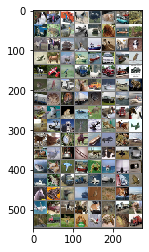

  dog   car truck horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
   
class AlexNet(nn.Module):
    def __init__(self, num_classes, inputs=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(inputs, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
net = AlexNet(10)
#net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [6]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
use_cuda = True

for epochs in range(epoch_n):
    train_loss = 0
    for i, data in enumerate(trainloader, 0):
        image, label = data
        if use_cuda:
            image, label = image.cuda(), label.cuda()
            net.cuda()
        optimizer.zero_grad()
        output = net(image)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epochs+1, i+1, train_loss / 2000))
            running_loss = 0
        
print('training finished')

NameError: name 'epoch_n' is not defined

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            net.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 9 %


In [8]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        
        images, labels = data
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Accuracy of plane : 41 %
Accuracy of   car :  0 %
Accuracy of  bird : 15 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship : 62 %
Accuracy of truck :  0 %

Test Accuracy (Overall): 11% (37/316)


In [13]:
class BBBConv2d(nn.Module):
    def __init__(self, q_logvar_init, p_logvar_init, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(BBBConv2d, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.q_logvar_init = q_logvar_init
        self.p_logvar_init = p_logvar_init
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias = bias

        self.mu_weight = Parameter(torch.Tensor(out_channels, 
                                                in_channels // groups, 
                                                kernel_size, 
                                                kernel_size))
        self.sigma_weight = Parameter(torch.Tensor(out_channels,
                                                   in_channels // groups, 
                                                   kernel_size, 
                                                   kernel_size))
        self.register_buffer('eps_weight', torch.Tensor(out_channels, 
                                                        in_channels // groups, 
                                                        kernel_size, 
                                                        kernel_size))
        
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        n *= self.kernel_size ** 2
        stdv = 1.0 / math.sqrt(n)
        self.mu_weight.data.uniform_(-stdv, stdv)
        self.sigma_weight.data.fill_(self.p_logvar_init)

    def forward(self, input):
        raise NotImplementedError()


    def convprobforward(self, input):
        sig_weight = torch.exp(self.sigma_weight)
        weight = self.mu_weight + sig_weight * self.eps_weight.normal_()
        kl_ = math.log(self.q_logvar_init) - self.sigma_weight + (sig_weight**2 + self.mu_weight**2) / (2 * self.q_logvar_init ** 2) - 0.5
        bias = None
        
        out = F.conv2d(input, weight, bias, self.stride, self.padding, self.dilation, self.groups)
        kl = kl_.sum() 
        return out, kl

class BBBLinearFactorial(nn.Module):
    def __init__(self, q_logvar_init, p_logvar_init, in_features, out_features, bias=False):
        super(BBBLinearFactorial, self).__init__()
        self.q_logvar_init = q_logvar_init
        self.in_features = in_features
        self.out_features = out_features
        self.p_logvar_init = p_logvar_init
        self.mu_weight = Parameter(torch.Tensor(out_features, in_features))
        self.sigma_weight = Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer('eps_weight', torch.Tensor(out_features, in_features))
        
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.mu_weight.size(1))
        self.mu_weight.data.uniform_(-stdv, stdv)
        self.sigma_weight.data.fill_(self.p_logvar_init)
        self.eps_weight.data.zero_()

    def forward(self, input):
        raise NotImplementedError()
        

    def fcprobforward(self, input):
        sig_weight = torch.exp(self.sigma_weight)
        weight = self.mu_weight + sig_weight * self.eps_weight.normal_()
        kl_ = math.log(self.q_logvar_init) - self.sigma_weight + (sig_weight**2 + self.mu_weight**2) / (2 * self.q_logvar_init ** 2) - 0.5
        bias = None
        out = F.linear(input, weight, bias)
        kl = kl_.sum() 
        return out, kl

class FlattenLayer(nn.Module):
    def __init__(self, num_features):
        super(FlattenLayer, self).__init__()
        self.num_features = num_features

    def forward(self, x):
        return x.view(-1, self.num_features)


class GaussianVariationalInference(nn.Module):
    def __init__(self, loss=nn.CrossEntropyLoss()):
        super(GaussianVariationalInference, self).__init__()
        self.loss = loss

    def forward(self, logits, y, kl, beta):
        logpy = self.loss(logits, y)

        loss = logpy + beta * kl  # ELBO

        return loss  

class BBBAlexNet(nn.Module):
    '''The architecture of AlexNet with Bayesian Layers'''

    def __init__(self, outputs, inputs):
        super(BBBAlexNet, self).__init__()

        self.p_logvar_init = 0.05
        self.q_logvar_init = math.log(0.05)


        self.conv1 = BBBConv2d(self.p_logvar_init, self.q_logvar_init, inputs, 64, kernel_size=11, stride=4, padding=5)
        self.soft1 = nn.Softplus()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(self.p_logvar_init, self.q_logvar_init, 64, 192, kernel_size=5, padding=2)
        self.soft2 = nn.Softplus()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = BBBConv2d(self.p_logvar_init, self.q_logvar_init, 192, 384, kernel_size=3, padding=1,)
        self.soft3 = nn.Softplus()

        self.conv4 = BBBConv2d(self.p_logvar_init, self.q_logvar_init, 384, 256, kernel_size=3, padding=1,)
        self.soft4 = nn.Softplus()

        self.conv5 = BBBConv2d(self.p_logvar_init, self.q_logvar_init, 256, 128, kernel_size=3, padding=1,)
        self.soft5 = nn.Softplus()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = FlattenLayer(1 * 1 * 128)
        self.fc1 = BBBLinearFactorial( self.p_logvar_init, self.q_logvar_init, 1* 1 * 128, outputs,)


        layers = [self.conv1, self.soft1, self.pool1, self.conv2, self.soft2, self.pool2, self.conv3, self.soft3,
                  self.conv4, self.soft4, self.conv5, self.soft5, self.pool3, self.flatten, self.fc1]

        self.layers = nn.ModuleList(layers)

    def probforward(self, x):
        'Forward pass with Bayesian weights'
        kl = 0
        for layer in self.layers:
            if hasattr(layer, 'convprobforward') and callable(layer.convprobforward):
                x, _kl, = layer.convprobforward(x)
                kl += _kl

            elif hasattr(layer, 'fcprobforward') and callable(layer.fcprobforward):
                x, _kl, = layer.fcprobforward(x)
                kl += _kl
            else:
                x = layer(x)
        logits = x
        return logits, kl

class BBBLeNet(nn.Module):
    '''The architecture of LeNet with Bayesian Layers'''

    def __init__(self, outputs, inputs):
        super(BBBLeNet, self).__init__()
        self.p_logvar = 0.05
        self.q_logvar = math.log(0.05)
        
        self.conv1 = BBBConv2d(self.p_logvar, self.q_logvar, inputs, 6, kernel_size=5, stride=1)
        self.soft1 = nn.Softplus()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(self.p_logvar, self.q_logvar,6, 16, 5, stride=1)
        self.soft2 = nn.Softplus()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = FlattenLayer(5 * 5 * 16)
        self.fc1 = BBBLinearFactorial(self.p_logvar, self.q_logvar, 5 * 5 * 16, 120)
        self.soft3 = nn.Softplus()

        self.fc2 = BBBLinearFactorial(self.p_logvar, self.q_logvar, 120, 84)
        self.soft4 = nn.Softplus()

        self.fc3 = BBBLinearFactorial(self.p_logvar, self.q_logvar, 84, outputs)

        layers = [self.conv1, self.soft1, self.pool1, self.conv2, self.soft2, self.pool2,
                  self.flatten, self.fc1, self.soft3, self.fc2, self.soft4, self.fc3]

        self.layers = nn.ModuleList(layers)

    def probforward(self, x):
        'Forward pass with Bayesian weights'
        kl = 0
        for layer in self.layers:
            if hasattr(layer, 'convprobforward') and callable(layer.convprobforward):
                x, _kl, = layer.convprobforward(x)
                kl += _kl

            elif hasattr(layer, 'fcprobforward') and callable(layer.fcprobforward):
                x, _kl, = layer.fcprobforward(x)
                kl += _kl
            else:
                x = layer(x)
        logits = x
        return logits, kl


In [14]:
net_bay = BBBLeNet(outputs,inputs)

vi = GaussianVariationalInference(torch.nn.CrossEntropyLoss())
optimizer = optim.Adam(net_bay.parameters(), lr=lr, weight_decay=weight_decay)

In [15]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
use_cuda = True
ckpt_name_bay = f'model_{net_type}_{dataset}_bayesian_bay.pth'

for epoch in range(n_epochs):
    m = math.ceil(len(trainset) / batch_size)
    train_loss = 0
    for batch_idx, data in enumerate(trainloader, 0):
        image, label = data
        #image = image.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        #label = label.repeat(num_samples)
        if use_cuda:
            image, label = image.cuda(), label.cuda()
            net_bay.cuda()
        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
        
        optimizer.zero_grad()
        output, kl= net_bay.probforward(image)
        loss = vi(output, label, kl, beta)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss = train_loss/(len(trainloader.dataset)) 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    torch.save(net_bay.state_dict(), ckpt_name_bay)
        
print('training finished')

Epoch: 0 	Training Loss: 0.321125
Epoch: 1 	Training Loss: 0.429739
Epoch: 2 	Training Loss: 0.280753
Epoch: 3 	Training Loss: 0.234754
Epoch: 4 	Training Loss: 0.217600
Epoch: 5 	Training Loss: 0.206131
Epoch: 6 	Training Loss: 0.192284
Epoch: 7 	Training Loss: 0.181062
Epoch: 8 	Training Loss: 0.173040
Epoch: 9 	Training Loss: 0.170308
Epoch: 10 	Training Loss: 0.172031
Epoch: 11 	Training Loss: 0.172684
Epoch: 12 	Training Loss: 0.173604
Epoch: 13 	Training Loss: 0.167901
Epoch: 14 	Training Loss: 0.158257
Epoch: 15 	Training Loss: 0.150806
Epoch: 16 	Training Loss: 0.146922
Epoch: 17 	Training Loss: 0.145514
Epoch: 18 	Training Loss: 0.145601
Epoch: 19 	Training Loss: 0.145775
Epoch: 20 	Training Loss: 0.145057
Epoch: 21 	Training Loss: 0.143147
Epoch: 22 	Training Loss: 0.141132
Epoch: 23 	Training Loss: 0.139484
Epoch: 24 	Training Loss: 0.138729
Epoch: 25 	Training Loss: 0.138453
Epoch: 26 	Training Loss: 0.138540
Epoch: 27 	Training Loss: 0.138404
Epoch: 28 	Training Loss: 0.13

In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
net_bay.load_state_dict(torch.load(ckpt_name_bay))
net_bay.eval()

m = math.ceil(len(testset) / batch_size)
for i, data in enumerate(testloader, 0):
        
    images, labels = data
    images = images.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
    labels = labels.repeat(num_samples)
    if use_cuda:
        images, labels = images.cuda(), labels.cuda()
        net_bay.cuda()    
    if beta_type is "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif cf.beta_type is "Soenderby":
        beta = min(epoch / (cf.num_epochs // 4), 1)
    elif cf.beta_type is "Standard":
        beta = 1 / m
    else:
        beta = 0
    
    outputs, kl= net_bay.probforward(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    #correct_tensor = predicted.eq(labels.data.view_as(predicted))
    #c = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        if i >= labels.data.shape[0]:
            break
        label = labels.data[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Accuracy of plane : 15 %
Accuracy of   car :  3 %
Accuracy of  bird : 13 %
Accuracy of   cat :  5 %
Accuracy of  deer :  6 %
Accuracy of   dog :  9 %
Accuracy of  frog : 11 %
Accuracy of horse : 13 %
Accuracy of  ship :  5 %
Accuracy of truck : 11 %

Test Accuracy (Overall):  9% (967/10000)


In [46]:
import torch

a = torch.randn(4, 4, 4, 4)
print(a.size())
b = a.view(-1, 256, 1, 1)
print(b.size())
c = b.repeat(2,1,1,1)
print(c.size())
d = torch.randn(10, 10)
print(d.size())
e = d.repeat(2)
print(e.size())
r = e.squeeze()
print(r.size())

torch.Size([4, 4, 4, 4])
torch.Size([1, 256, 1, 1])
torch.Size([2, 256, 1, 1])
torch.Size([10, 10])


RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

In [19]:
import torch
import math
a = torch.randn(4, 4)
print(a, a.size())
b = a.data
print(b, b.size())
c = b.fill_(math.log(1))
print(c, c.size())

tensor([[ 2.2306,  3.1204,  0.3488, -1.8445],
        [-1.1171, -0.7675, -0.7599, -0.9407],
        [-1.0253, -0.0859, -1.2390,  0.3880],
        [-0.2884, -1.0030,  0.5398, -1.1373]]) torch.Size([4, 4])
tensor([[ 2.2306,  3.1204,  0.3488, -1.8445],
        [-1.1171, -0.7675, -0.7599, -0.9407],
        [-1.0253, -0.0859, -1.2390,  0.3880],
        [-0.2884, -1.0030,  0.5398, -1.1373]]) torch.Size([4, 4])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]) torch.Size([4, 4])


In [20]:
import torch
a = torch.randn(2,4)
print(a, a.size())
b = a.normal_()
print(b, b.size())

tensor([[ 0.9416, -1.3759, -0.4019, -0.4097],
        [ 1.7595, -0.5978, -1.0626,  1.3369]]) torch.Size([2, 4])
tensor([[ 0.7022,  1.0111,  0.8032,  0.1906],
        [ 0.0216,  0.3131, -1.9582,  0.5634]]) torch.Size([2, 4])


In [22]:
import torch
a = torch.randn(3,2)
print(a, a.size())
b = torch.exp(a)
print(b, b.size())

tensor([[ 1.5133e-01,  2.4482e+00],
        [-1.1280e+00,  6.2099e-04],
        [ 7.8104e-01,  3.9582e-01]]) torch.Size([3, 2])
tensor([[ 1.1634, 11.5676],
        [ 0.3237,  1.0006],
        [ 2.1837,  1.4856]]) torch.Size([3, 2])
